### 1. Análisis de datos

In [1]:
# Importando librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

import datetime

# Cargando datos
df = pd.read_excel("Retail_Invoices.xlsx")
df.head()

,InvoiceNo,InvoiceDate,CustomerID,Quantity,price_total,StockCode
0,536365,2010-12-01,17850,40,139.12,7
1,536366,2010-12-01,17850,12,22.20,2
2,536367,2010-12-01,13047,83,278.73,12
3,536368,2010-12-01,13047,15,70.05,4
4,536369,2010-12-01,13047,3,17.85,1


In [2]:
# Ver datos generales
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22190 entries, 0 to 22189
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   InvoiceNo    22190 non-null  object        
 1   InvoiceDate  22190 non-null  datetime64[ns]
 2   CustomerID   22190 non-null  int64         
 3   Quantity     22190 non-null  int64         
 4   price_total  22190 non-null  float64       
 5   StockCode    22190 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 1.0+ MB
None
                         InvoiceDate    CustomerID      Quantity  \
count                          22190  22190.000000  22190.000000   
mean   2011-06-29 05:59:15.223073536  15238.498738    221.130599   
min              2010-12-01 00:00:00  12346.000000 -80995.000000   
25%              2011-03-29 00:00:00  13755.000000     30.000000   
50%              2011-07-08 00:00:00  15136.000000    120.000000   
75%   

In [3]:
# Ver valores nulos
print(df.isnull().sum())

InvoiceNo      0
InvoiceDate    0
CustomerID     0
Quantity       0
price_total    0
StockCode      0
dtype: int64


In [4]:
# Limpieza de datos
# Eliminar registros con CustomerId nulo 
df = df.dropna(subset=['CustomerID'])

# Eliminar registros con cantidades o precios <= 0
df = df[(df['Quantity'] > 0) & (df['price_total'] > 0)]

print(df.describe())

                         InvoiceDate    CustomerID      Quantity  \
count                          18532  18532.000000  18532.000000   
mean   2011-07-01 03:39:44.718324736  15266.378211    278.899363   
min              2010-12-01 00:00:00  12346.000000      1.000000   
25%              2011-03-30 00:00:00  13776.250000     74.000000   
50%              2011-07-12 00:00:00  15178.500000    155.000000   
75%              2011-10-12 00:00:00  16779.000000    291.000000   
max              2011-12-09 00:00:00  18287.000000  80995.000000   
std                              NaN   1734.116296    972.734580   

         price_total     StockCode  
count   18532.000000  18532.000000  
mean      480.865956     21.471886  
min         0.380000      1.000000  
25%       158.037500      6.000000  
50%       303.040000     15.000000  
75%       471.840000     28.000000  
max    168469.600000    542.000000  
std      1678.195579     24.920241  


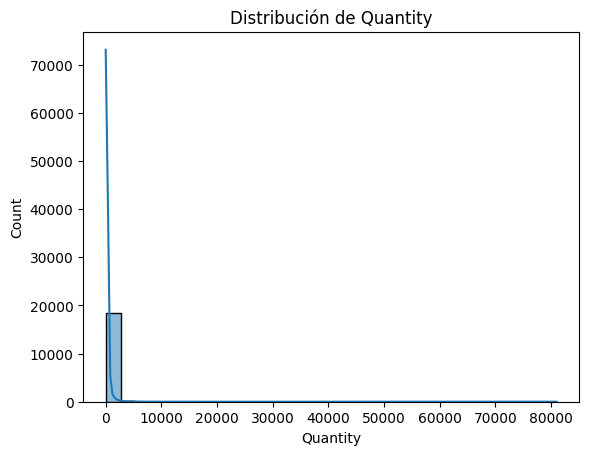

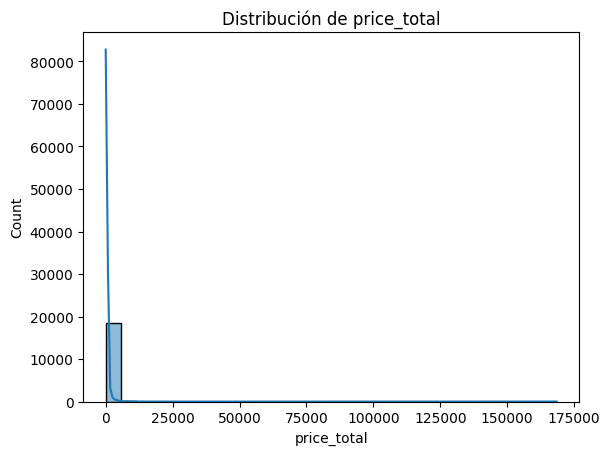

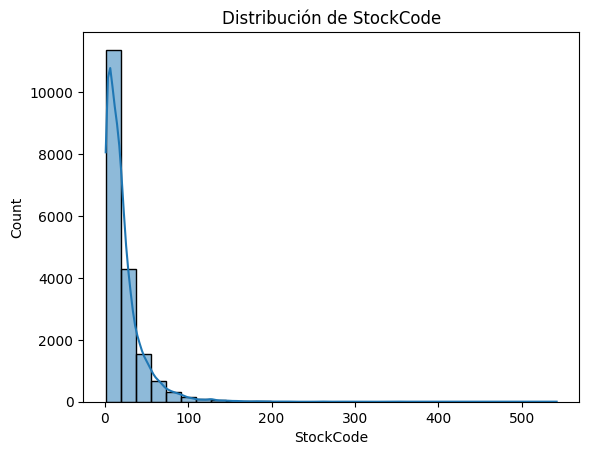

In [5]:
# Distribuciones básicas
for col in ['Quantity', 'price_total', 'StockCode']:
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Distribución de {col}")
    plt.show()

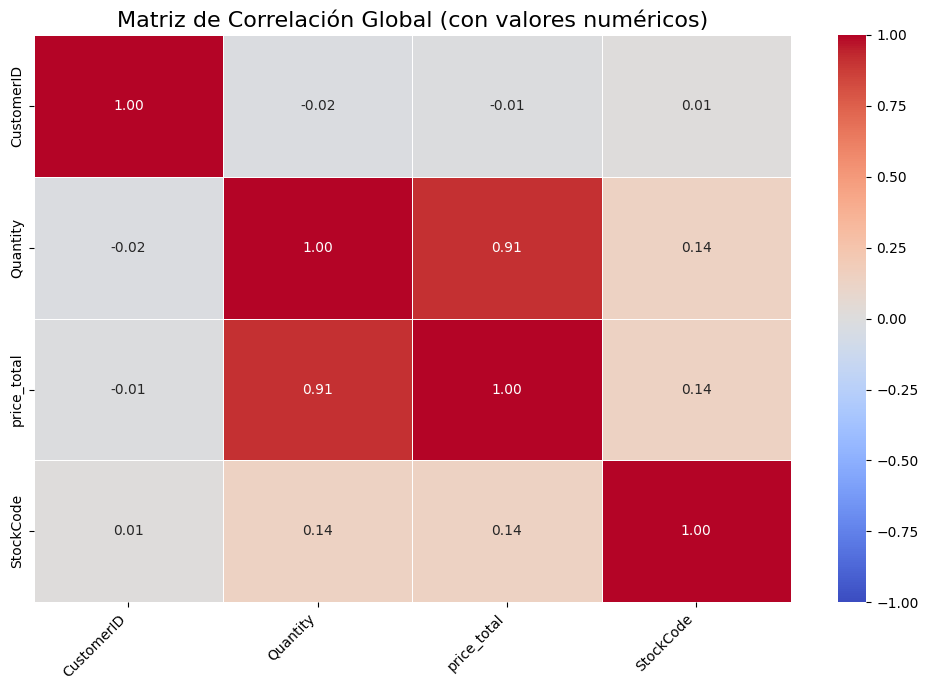

In [6]:
# Matriz de correlación
correlation_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(10, 7))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.5,
    vmin=-1,
    vmax=1
)
plt.xticks(rotation=45, ha='right')
plt.title("Matriz de Correlación Global (con valores numéricos)", fontsize=16)
plt.tight_layout()
plt.show()

### 2. Generando variables RFM

In [7]:
# Asegurar formato de fecha
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Definir la fecha de referencia para Recency 
reference_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print("Fecha de referencia:", reference_date)

# Calcular RFM
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'price_total': 'sum'
}).reset_index()

rfm.columns = ['CustomerID', 'Recencia', 'Frecuencia', 'Monto']

rfm.head()

Fecha de referencia: 2011-12-10 00:00:00


,CustomerID,Recencia,Frecuencia,Monto
0,12346,326,1,77183.60
1,12347,3,7,4310.00
2,12348,76,4,1797.24
3,12349,19,1,1757.55
4,12350,311,1,334.40


### 3. Análisis exploratorio a las nuevas variables

         CustomerID     Recencia   Frecuencia          Monto
count   4338.000000  4338.000000  4338.000000    4338.000000
mean   15300.408022    93.059474     4.272015    2054.266460
std     1721.808492   100.012264     7.697998    8989.230441
min    12346.000000     1.000000     1.000000       3.750000
25%    13813.250000    18.000000     1.000000     307.415000
50%    15299.500000    51.000000     2.000000     674.485000
75%    16778.750000   142.750000     5.000000    1661.740000
max    18287.000000   374.000000   209.000000  280206.020000


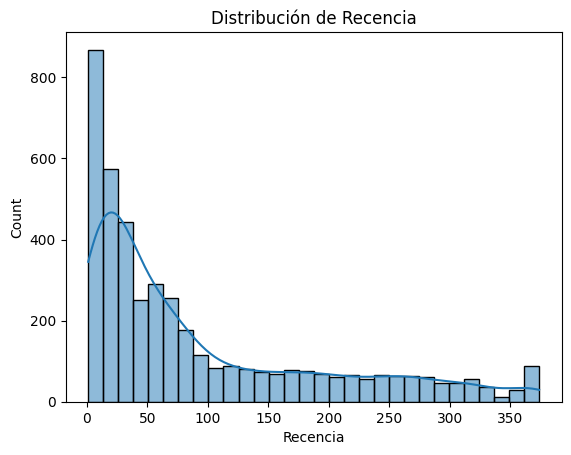

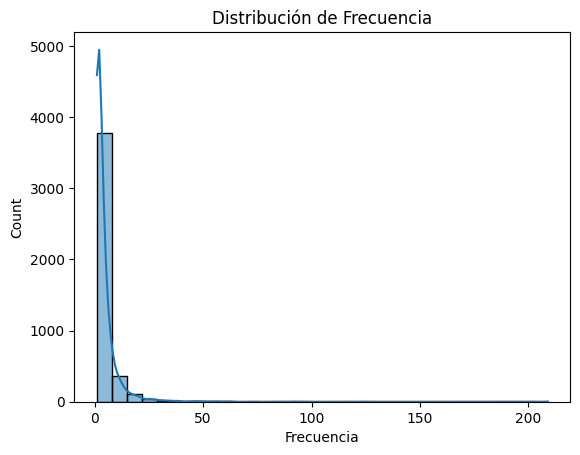

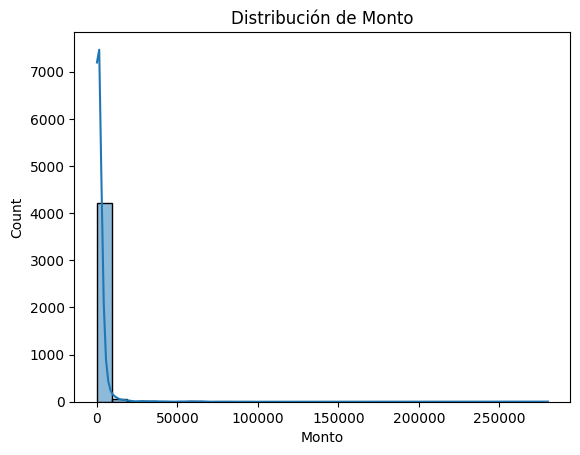

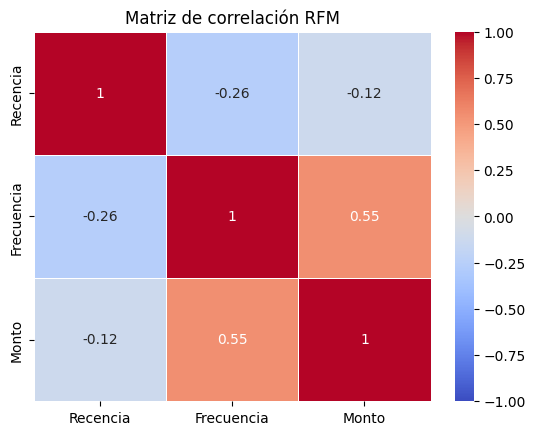

In [8]:
# Estadísticas
print(rfm.describe())

# Distribuciones
for col in ['Recencia', 'Frecuencia', 'Monto']:
    sns.histplot(rfm[col], bins=30, kde=True)
    plt.title(f"Distribución de {col}")
    plt.show()

# Correlaciones
sns.heatmap(rfm[['Recencia', 'Frecuencia', 'Monto']].corr(), annot=True, cmap='coolwarm',linewidths=0.5,
    vmin=-1,
    vmax=1)
plt.title("Matriz de correlación RFM")
plt.show()

### 4. Aplicando algoritmos de clustering

In [9]:
# Seleccionar variables nuevas de RFM
rfm_data = rfm[['Recencia', 'Frecuencia', 'Monto']].dropna()
print(rfm.columns)

# Función para graficar clustering
def plot_clusters_rfm(scaled_rfm, labels, title):
    plt.figure(figsize=(8, 6))
    sns.scatterplot(
        x=scaled_rfm[:, 0],   # Recencia (scaled)
        y=scaled_rfm[:, 1],   # Frecuencia (scaled)
        hue=labels,
        palette='Set2',
        s=60,
        edgecolor='black'
    )
    plt.title(title)
    plt.xlabel('Recencia (scaled)')
    plt.ylabel('Frecuencia (scaled)')
    plt.legend(title='Cluster')
    plt.show()

# Escalamiento de datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(rfm_data)
scaled_rfm = pd.DataFrame(scaled_data, columns=['Recencia (scaled)', 'Frecuencia (scaled)', 'Monto (scaled)'])

Index(['CustomerID', 'Recencia', 'Frecuencia', 'Monto'], dtype='object')


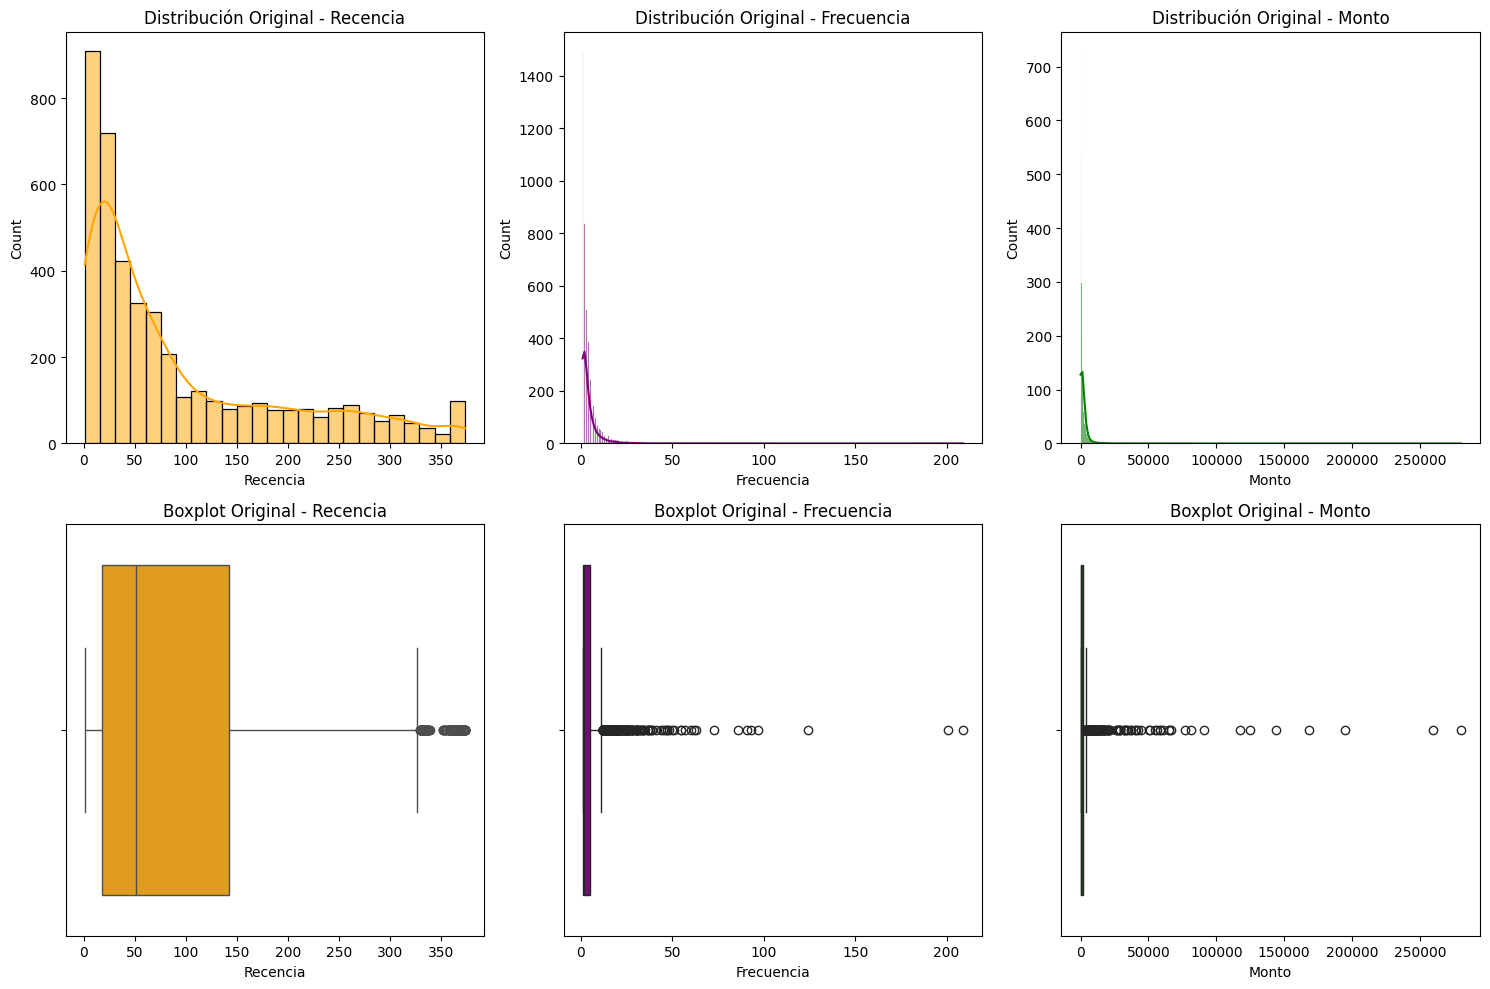

In [10]:
# Distribuciones y boxplots antes del escalado
# Figura original
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Histrogramas
sns.histplot(rfm_data['Recencia'], kde=True, ax=axes[0, 0], color='orange')
axes[0, 0].set_title('Distribución Original - Recencia')

sns.histplot(rfm_data['Frecuencia'], kde=True, ax=axes[0, 1], color='purple')
axes[0, 1].set_title('Distribución Original - Frecuencia')

sns.histplot(rfm_data['Monto'], kde=True, ax=axes[0, 2], color='green')
axes[0, 2].set_title('Distribución Original - Monto')

# Boxplots
sns.boxplot(x=rfm_data['Recencia'], ax=axes[1, 0], color='orange')
axes[1, 0].set_title('Boxplot Original - Recencia')

sns.boxplot(x=rfm_data['Frecuencia'], ax=axes[1, 1], color='purple')
axes[1, 1].set_title('Boxplot Original - Frecuencia')

sns.boxplot(x=rfm_data['Monto'], ax=axes[1, 2], color='green')
axes[1, 2].set_title('Boxplot Original - Monto')

plt.tight_layout()
plt.show()

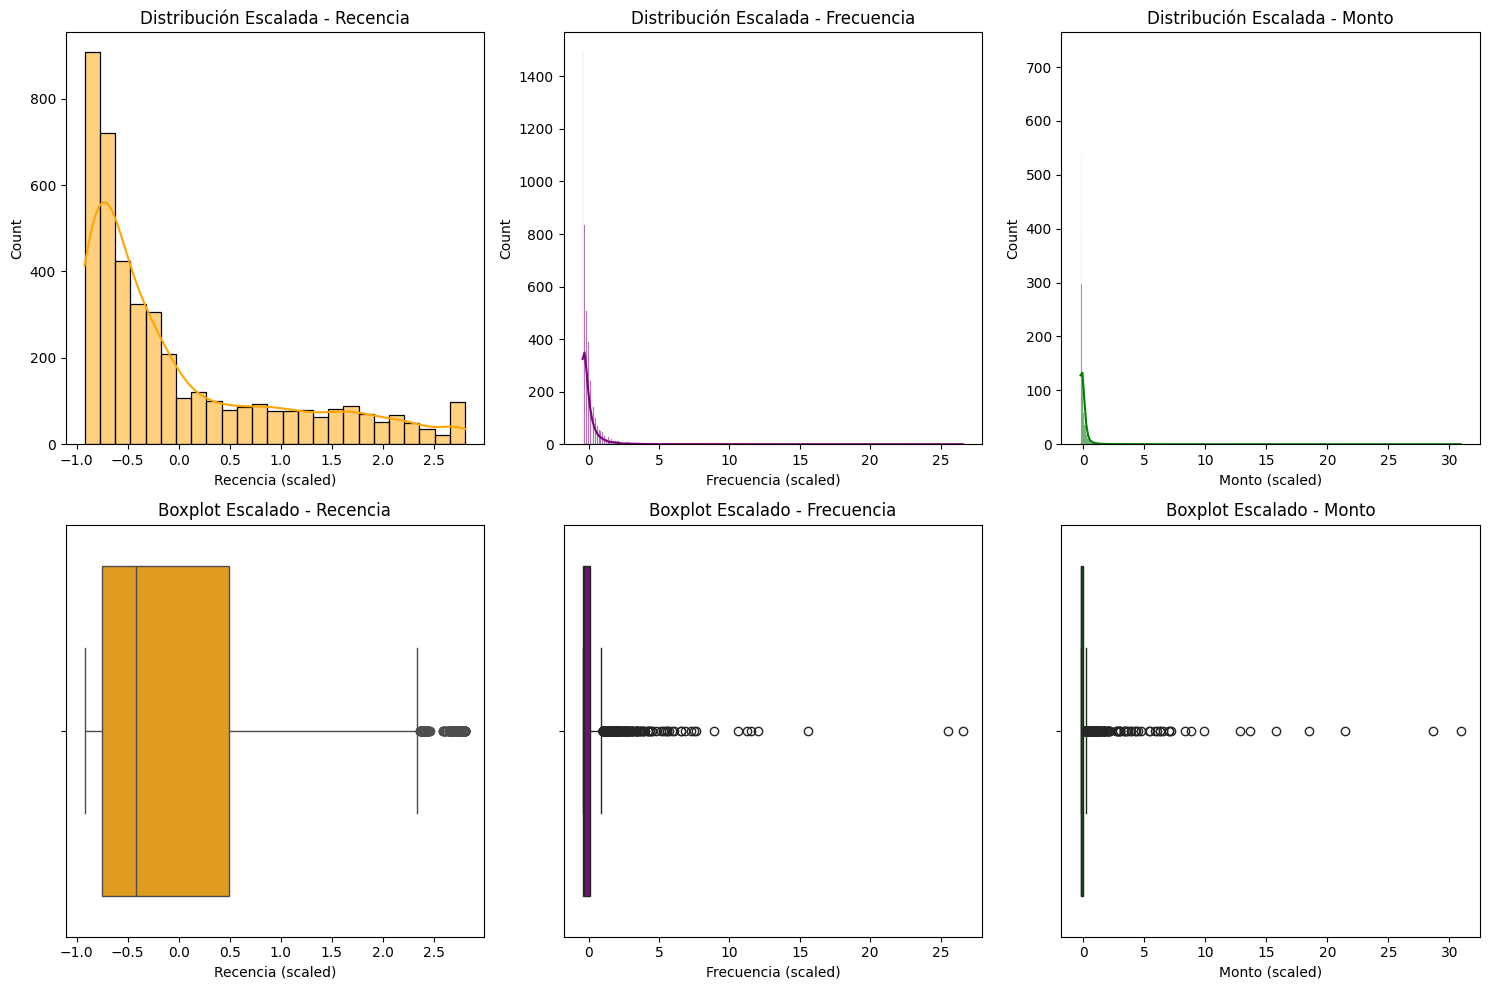

In [12]:
# Distribuciones y boxplots después del escalado
# Figura escalada
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Histogramas escalados
sns.histplot(scaled_rfm['Recencia (scaled)'], kde=True, ax=axes[0, 0], color='orange')
axes[0, 0].set_title('Distribución Escalada - Recencia')

sns.histplot(scaled_rfm['Frecuencia (scaled)'], kde=True, ax=axes[0, 1], color='purple')
axes[0, 1].set_title('Distribución Escalada - Frecuencia')

sns.histplot(scaled_rfm['Monto (scaled)'], kde=True, ax=axes[0, 2], color='green')
axes[0, 2].set_title('Distribución Escalada - Monto')

# BOXPLOTS ESCALADOS
sns.boxplot(x=scaled_rfm['Recencia (scaled)'], ax=axes[1, 0], color='orange')
axes[1, 0].set_title('Boxplot Escalado - Recencia')

sns.boxplot(x=scaled_rfm['Frecuencia (scaled)'], ax=axes[1, 1], color='purple')
axes[1, 1].set_title('Boxplot Escalado - Frecuencia')

sns.boxplot(x=scaled_rfm['Monto (scaled)'], ax=axes[1, 2], color='green')
axes[1, 2].set_title('Boxplot Escalado - Monto')

plt.tight_layout()
plt.show()

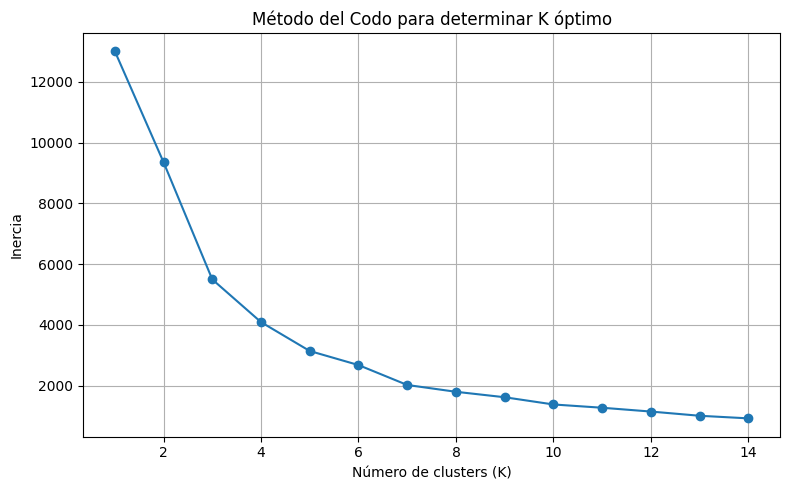

Estimated k: 3


In [13]:
# Método del codo
inertias    = []
K_range     = range(1, 15)
for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42)
    kmeans_temp.fit(scaled_data)
    inertias.append(kmeans_temp.inertia_)

# Graficar el método del codo
plt.figure(figsize=(8, 5))
plt.plot(K_range, inertias, marker='o')
plt.title('Método del Codo para determinar K óptimo')
plt.xlabel('Número de clusters (K)')
plt.ylabel('Inercia')
plt.grid(True)
plt.tight_layout()
plt.show()

# Estimar el codo de forma simple
differences = np.diff(inertias)
relative_change = np.abs(np.diff(differences))
estimated_k = np.argmax(relative_change) + 2
print("Estimated k:", estimated_k)

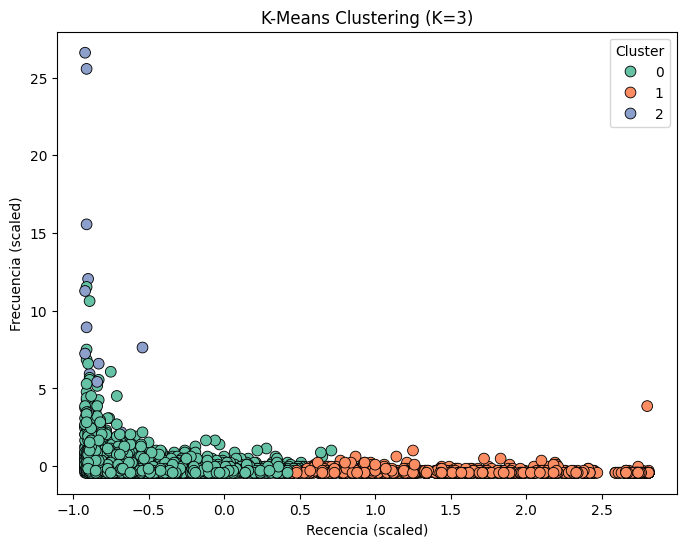

In [14]:
# Aplicar K-Means con K=estimated_k
kmeans = KMeans(n_clusters=estimated_k, random_state=42)
kmeans_labels = kmeans.fit_predict(scaled_data)
plot_clusters_rfm(scaled_data, kmeans_labels, f"K-Means Clustering (K={estimated_k})")

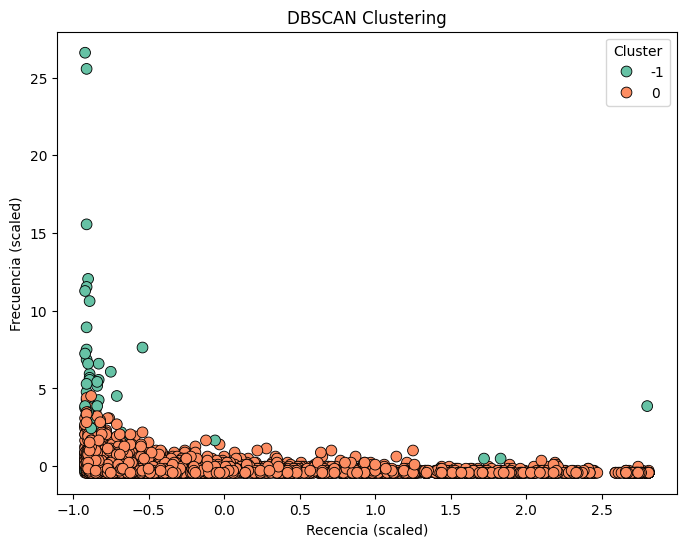

In [15]:
# Aplicar DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(scaled_data)
plot_clusters_rfm(scaled_data, dbscan_labels, "DBSCAN Clustering")

In [16]:
# Calcular Silhouette para K MEANS
if estimated_k > 1:  # Silhouette necesita al menos 2 clusters
    sil_kmeans = silhouette_score(scaled_data, kmeans_labels)
    print(f"Silhouette Score (KMeans, k={estimated_k}): {sil_kmeans:.3f}")
else:
    print("No se puede calcular Silhouette para KMeans con menos de 2 clusters.")

Silhouette Score (KMeans, k=3): 0.585


#### Interpretación de resultado: 0.585 es un punto cercano 1, por tanto, eso indica que el punto está bien agrupado

In [17]:
# Calcular Silhouette Score para DBSCAN
# DBSCAN puede asignar -1 a "ruido", hay que checar clusters válidos
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)

if n_clusters_dbscan > 1:
    sil_dbscan = silhouette_score(scaled_data, dbscan_labels)
    print(f"Silhouette Score (DBSCAN, clusters={n_clusters_dbscan}): {sil_dbscan:.3f}")
else:
    print(f"No se puede calcular Silhouette para DBSCAN: solo encontró {n_clusters_dbscan} cluster(s) válido(s).")

No se puede calcular Silhouette para DBSCAN: solo encontró 1 cluster(s) válido(s).


### 5. Evaluar la calidad de los clustering de forma numérica

In [18]:
# Añadir etiquetas de cluster al DataFrame RFM original
rfm['Cluster_KMeans'] = kmeans_labels

# Calcular medias por cluster para interpretar segmentos
cluster_summary = rfm.groupby('Cluster_KMeans')[['Recencia', 'Frecuencia', 'Monto']].mean().round(2)
display(cluster_summary)

,Recencia,Frecuencia,Monto
Cluster_KMeans,,,
0,41.58,4.85,2011.56
1,246.72,1.58,630.24
2,7.36,80.21,122888.41


In [19]:
# Definir nombres descriptivos para cada segmento
cluster_names = {
    0: "Clientes Regulares",
    1: "Clientes Inactivos",
    2: "Clientes Premium"
}

rfm['Segmento_KMeans'] = rfm['Cluster_KMeans'].map(cluster_names)
rfm.head()

,CustomerID,Recencia,Frecuencia,Monto,Cluster_KMeans,Segmento_KMeans
0,12346,326,1,77183.60,1,Clientes Inactivos
1,12347,3,7,4310.00,0,Clientes Regulares
2,12348,76,4,1797.24,0,Clientes Regulares
3,12349,19,1,1757.55,0,Clientes Regulares
4,12350,311,1,334.40,1,Clientes Inactivos


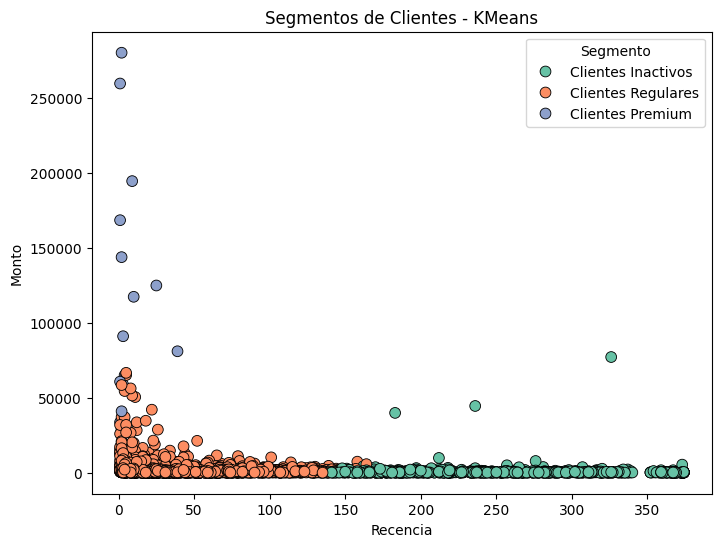

In [20]:
# Visualización de segmentos
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=rfm, 
    x='Recencia', 
    y='Monto', 
    hue='Segmento_KMeans', 
    palette='Set2',
    s=60,
    edgecolor='black'
)
plt.title('Segmentos de Clientes - KMeans')
plt.xlabel('Recencia')
plt.ylabel('Monto')
plt.legend(title='Segmento')
plt.show()

# Interpretación de resultados

### - Clientes Premium (Cluster 2) 
####   * Compran muy recientemente (baja recencia)
####   * Montos de compras muy altos
####   * Altra frecuencia de compra

### - Clientes Regulares (Cluster 0)
####   * Recencia moderada
####   * Frecuencia moderada
####   * Monto medio alto

### - Clientes Inactivos (Cluster 1)
####   * Recencia muy alta (hace mucho que no compran)
####   * Frecuencia baja
####   * Monto bajo